In [15]:
# %matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle
from astropy.time import Time
from astropy import units as u
import tqdm
import random
import string
from astropy.visualization import astropy_mpl_style, quantity_support

# Pipeline

### 17th Feb:

**Conditional about observations:**

The user gives the latitude and the functions returns if the phenomenon can be see it or not. This using the conditional "altitude > 0 degrees" but with the difference of taking into account the time of observation on the altitude-Azimuth coordinate system; this is the equivalent ofr the conditional of "dec > 90-latitude".   

Alert system's input format: RA, Dec (hmsdms); Latitude, longitude (DMS); militar hour (hms) using J200 
(Reference: https://ztf.uw.edu/alerts/public/)

**About the sing on the coordinates**
 A positive value for North and East, a negative value for South and West. (Reference: https://tnp.uservoice.com/knowledgebase/articles/172110-latitude-longitude-formats-and-conversion)

 ### 21th Feb

Now we need to expand the function for a time slot, establish by the user. With this condition, is necesary to report if its observable. An idea is refreshing the dataframe with a nonsmall step, such we can determine if the function is returning what we want. 

Change the scale of time to UTC and keep the format iso for maintain the international format.

Actually, the function Time of astropy simplifies the code because allows sum seconds, hour and minutes in a line.
(Reference: https://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time.FORMATS)

### 24 Feb - 3 Mar
This week have three objectives: 

1) Implement a preference condition, just show the observables and organized with preference of higher altitude. The preference it gonna be a color code:

    Priority: Extraordinary: Green;  High: Orange; Medium: Blue; Low: Pink

2) Try to simulate for see in the time slot only the observables with the observer as the center. First we need to get the coordinates of the observables in the altaz format.

3) Change the enter for a dataframe with the transients information.

### 3 Mar - 9 Mar
This week we redefine the way of give the data required for observation and the priority with the plot of altitude vs time. This lead us to redefine and rewrite the code structure and logic. All for working with time. 

### 10 Mar- 19 Mar
We are gonna try with real data from Stellarium taking random objects of the new general catalogue and the position right Bogotá. But the code don´t go for the graphics, we need to establish another array for the time as the all objects doesnt have the same length. 

And now we have the code for general number of observations.

### 19 Mar
We are gonna try now with random data (literally random) for see haw it goes. And we need to change the order of observation because the limit of observations is the limit for good observations (change two variables).

And we wany to change the format DMS of observer coordinates for degrees just for facilities.

### 31 Mar

We change the plot output for 100 and 1000 random positions. 

### 3 April

I change and fix the code about order and priorization. Furthermore, was necesary to check the time of running.

### 8 April

Now I need to take into account the exposition time of every object that is posible to see in the location and now establish the order of observations in based of that.

The simplest model for the time exposition is:
$$ t = K × 10^{(0.4 × (m - m_{ref}))}$$

Where $m$ is the visual magnitude, $m_{ref}$ is a reference magnitude, and $K$ is a constant who depends on the telescope. The free parameters are $K$ and $m_{ref}$

So we can order but now we see both altitude and time exposition parameters

Ref: https://arxiv.org/pdf/2504.03666

### 17 April

The code now stablish an order based on exposition time of each observable. In every case, it returns a dataframe with the order and time of observation

# General functions

In [ ]:
#Made the delta time for the graphic
def DeltaTime(Date_i,Date_f,t_scale):

    scale = t_scale[0]
    sc = t_scale[1]

    a = Time(Date_i,format = 'iso', scale='utc').datetime.hour-24
    b = Time(Date_f,format = 'iso', scale='utc').datetime.hour

    if scale == 's':
        len = int((b-a)/ (sc/3600))
        t_ = np.linspace(a , b , len) 
   
    if scale == 'm':
        len = int((b-a)/ (sc/60))
        t_ = np.linspace(a , b , len)
    
    if scale == 'h':
        len = int((b-a)/ sc)
        t_ = np.linspace(a , b , len)
    
    return t_

#Made the array of time around of midnight
def CreateTime(Date_i,Date_f,t_scale):

    time_midnight = Time( Time(Date_i,format = 'iso', scale='utc').iso.split()[0] + ' 00:00:00' ,format = 'iso', scale='utc')

    delta = DeltaTime(Date_i,Date_f,t_scale)*u.hour

    return time_midnight + delta

#Return the classified observations
def Observations(observer, alert, Date_i, Date_f,time_scale,rango,limit,m_min):

    #Definition of different variables:
    time = CreateTime(Date_i,Date_f,time_scale) #return a array

    lat_conv , lon_conv = observer
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)

    #Lists of data for post-analysis
    Big_Data = []

    #Give the label of identification of each object
    alert['Label'] = range(1, rango)

    #Give the conditional for the minimum observation
    alert['V mag'] = alert['Mag'] <= m_min

    #Get off which can not be visible and Quit that column because its just an indicator
    alert = alert[alert['V mag'] != False].drop(['V mag'],axis=1)

    #Establish the time slot
    for each_time in time:

        #For each time slot we need the data of the conditional about observations
        
        #Establish the coordinates with the correction from geocentric calculations of astropy
        celestial_coord = SkyCoord(ra=alert['RA'], dec=alert['DEC']) #Mantain the degrees units

        # Calculate the coordenates AltAz for the time and observer and transform the J2000 coordinate system for altaz
        altaz_coord = celestial_coord.transform_to( AltAz(obstime=each_time, location=observer) ) 
    
        # Determinate if its observable and a good observable (altitude > 33 degrees) in the altaz coordinate system, return a boolean.
        state  = altaz_coord.alt > limit*u.deg

        #Put the things together
        alert['Observable'] = state
        alert['Az'] = altaz_coord.az.deg
        alert['Alt'] = altaz_coord.alt.deg
        
        #Put the conditionals of a time slot on a dataframe in the format for better reading
        Data = alert.copy()
        
        #Put the dataframe in a list and the values of time
        Big_Data.append(Data) 

    #With the DataFrame we can organice all the observations
    final_data = pd.concat(Big_Data,axis=0)

    return final_data


#Calculate exposition time
def ExpositionTime(K, m, m_ref):
    return K*(10**(0.4*(m - m_ref)))


#Return the dataframe with the information about graphic and order
def OrderLimits(Data,rango,Time,General_time,t_expo,K,m_ref):
    targets = []
    order = [] 

    for i in range(1,rango):
        #Organize and add time to the dataframe
        Target = Data.loc[Data['Label'] == i].copy()
        if Target.empty:
            continue
        
        Target['Time'] = Time
        Target['Time expo'] = ExpositionTime(K, Target['Mag'], m_ref)
        Target = Target[(Target['Observable'] != False) & (Target['Time expo'] <= t_expo)]

        #Take from dataframe just the observables
        if not Target.empty:
            targets.append(Target)

    if not targets:
        return [], pd.DataFrame()

    #Concate everything for a better analysis
    obs = pd.concat(targets,axis=0).reset_index(drop=True).drop(['Observable'],axis=1)


    #Determine the flag variables for the cycle, the first position is gonna be always the first point
    first_target = obs[obs['Time'] == Time[0]]
    if not first_target.empty:
        first_target = first_target.sort_values(by='Alt', ascending=False, na_position='first').head(1)
        first_target['Time'] = General_time[0]
        order.append(first_target)
        
        time_flag = General_time[0] + first_target['Time expo'].iloc[0] * u.second
        position_flag = first_target
    else:
        time_flag = General_time[0]
        position_flag = pd.DataFrame()


    #Stablish the order of observation by highest altitude and the time exposition
    for i in range(1,len(Time)):
        #Organice by highest altitude
        priority = obs.loc[obs['Time'] == Time[i]].sort_values('Alt', ascending=False, na_position='first').head(1)
        current_time = General_time[i]

        #No matter if we have an empty entrace
        if priority.empty:
            continue

        #Give the time for the observable
        priority['Time'] = current_time

        #No take the empty dataframes
        if priority.empty==False:

            if time_flag >= current_time:

                if not position_flag.empty and position_flag['Label'].iloc[0] == priority['Label'].iloc[0]:
                    order.append(priority)
                else:
                    position_flag['Time'] = current_time
                    order.append(position_flag)
            else:
                order.append(priority)
                time_flag = current_time + priority['Time expo'].iloc[0] * u.second
                position_flag = priority

    #Take just the dataframe necessary
    order = pd.concat(order,axis=0).reset_index(drop=True).drop(['Az','Alt'],axis=1)

    return targets, order


In [17]:
#Playtime data

#Tuple in order of (latitude,longitude) in degrees
observer = 4.609 , -74.081
 
#Slot of time and date
date_i = '2025-03-13 19:00:00'
date_f = '2025-03-14 07:00:00'

#Time scale of the observation, the minimum is 5 seconds
timescale = ['m', 15]

#Limit of telescopes for good observations, usually are 33 degree on altitude
limit = 33 

# Limit on magnitude for the specific telescope
m_min = 30

# Parameter K and m_ref, random numbers until i define the units
K = 10
m_ref = 10 

#Minimum time for exposition that have the telescope in seconds
t_expo = 30

#RANDOM DATA
def random_data(n):
    #random names
    nombres = [''.join(random.choices(string.ascii_uppercase, k=random.randint(5, 7))) for _ in range(n)]
    
    #random ra
    ra = [f"{random.randint(0, 23):02d}h{random.randint(0, 59):02d}m{random.randint(0, 59):02d}.{random.randint(0, 99):02d}s" 
          for _ in range(n)]
    
    #random dec
    dec = [f"{random.choice(['+', '-'])}{random.randint(0, 89):02d}d{random.randint(0, 59):02d}m{random.randint(0, 59):02d}.{random.randint(0, 90):02d}s" 
           for _ in range(n)]
    
    #random magnitude
    mag = [random.randint(-5, 20) for _ in range(n)]
    
    #Create the dataframe
    df = pd.DataFrame({
        'Name': nombres,
        'RA': ra,
        'DEC': dec,
        'Mag': mag})
    
    return df


## 10 random targets

In [18]:
#Dataframe with random targets
alerts = random_data(10)

#Amount of targets, this is for the labels of graphic
many = len(alerts) + 1

#Observations with the data
Data = Observations(observer, alerts, date_i, date_f,timescale,many,limit,m_min)
time = DeltaTime(date_i,date_f,timescale)
general_time = CreateTime(date_i,date_f,timescale)
graphic,order = OrderLimits(Data,many,time,general_time,t_expo,K,m_ref)

print('Order for observation')
order

Order for observation


,Name,RA,DEC,Mag,Label,Time,Time expo
0,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 19:30:38.298,1.584893
1,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 19:45:57.447,1.584893
2,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 20:01:16.596,1.584893
3,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 20:16:35.745,1.584893
4,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 20:31:54.894,1.584893
5,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 20:47:14.043,1.584893
6,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 21:02:33.191,1.584893
7,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 21:17:52.340,1.584893
8,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 21:33:11.489,1.584893
9,FUKHSO,05h08m21.62s,+42d02m50.30s,8,4,2025-03-12 21:48:30.638,1.584893


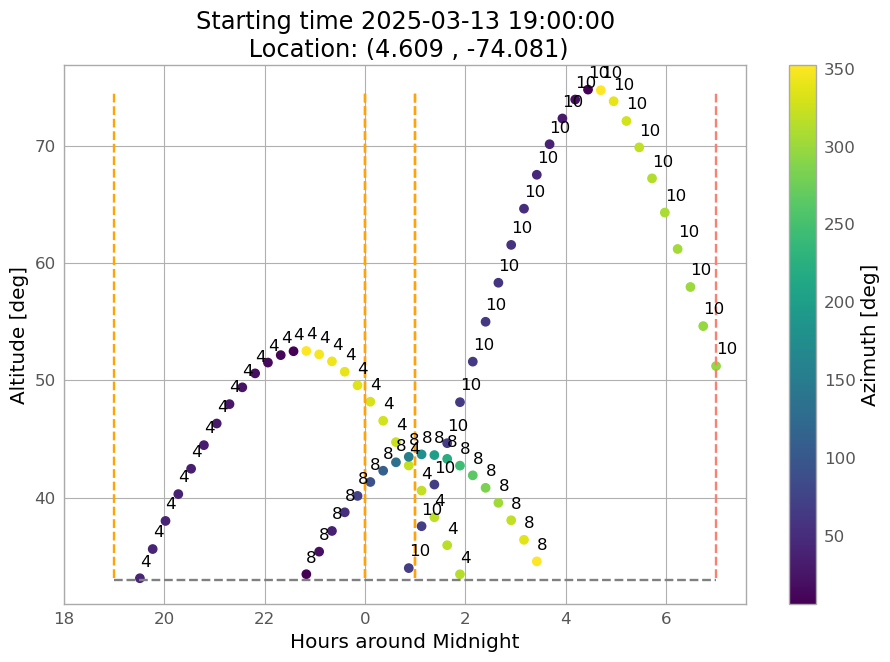

In [19]:
plt.figure(figsize=(11,7))
plt.style.use(astropy_mpl_style)
quantity_support()

ordertime = []
min_alt = []
max_alt = []
orderlabels = [i for i in order['Label'].drop_duplicates()]

for i in orderlabels: 
    hour_i = order.loc[order['Label']==i].head(1)['Time'].iloc[0].datetime.hour
    hour_f = order.loc[order['Label']==i].tail(1)['Time'].iloc[0].datetime.hour
    
    if 13 <= hour_i <= 23:
        hour_i = hour_i-24
    if 13 <= hour_f <= 23:
        hour_f = hour_f-24
        
    ordertime.append((hour_i,hour_f))


for each in graphic:
    if each['Label'].iloc[0] in orderlabels:

        ALT = each['Alt'].tolist()
        AZ = each['Az'].tolist()
        T = each['Time'].tolist()

        plt.scatter(T, ALT,c=AZ,cmap="viridis",lw=1)

        for j, alt in enumerate(ALT):
            plt.annotate(str(each['Label'].iloc[0]), (T[j], alt + 1), color='k')        

        min_alt.append(min(ALT))
        max_alt.append(max(ALT))

# Limits of good observations
plt.plot(time, [limit] * len(time), '--', color='grey')
#Details
plt.colorbar().set_label("Azimuth [deg]")
plt.xlabel("Hours around Midnight")
plt.ylabel("Altitude [deg]")

# Limits of good observations
for each in ordertime:
    plt.plot([each[0]] * len(np.linspace(min(min_alt),max(max_alt), len(time))), np.linspace(min(min_alt),max(max_alt), len(time)), '--', color='orange')
    plt.plot([each[1]] * len(np.linspace(min(min_alt),max(max_alt),len(time))), np.linspace(min(min_alt),max(max_alt), len(time)), '--', color='salmon')

#Exes
hours = [str(round(num + 24,1)) if num < 0 else str(round(num,1)) for num in np.array([-6,-4,-2,0,2,4,6])]
plt.xticks(np.array([-6,-4,-2,0,2,4,6]), hours)
plt.title('Starting time {}\n Location: ({} , {})'.format(date_i,observer[0],observer[1]))


plt.show()



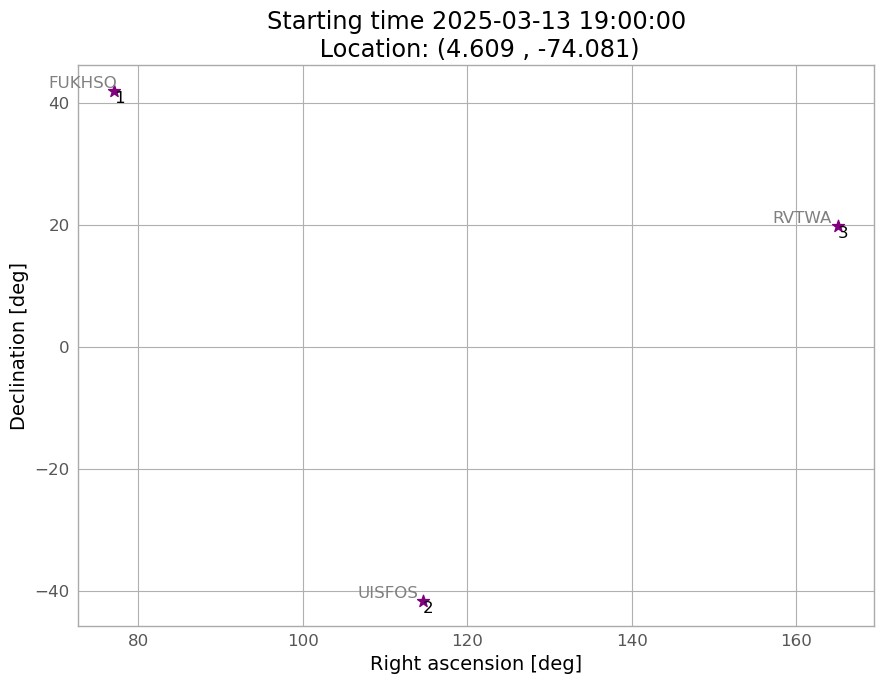

In [20]:
plt.style.use(astropy_mpl_style)
quantity_support()

names = [i for i in order['Name'].drop_duplicates()]
ra = [Angle(i, unit=u.deg).degree for i in order['RA'].drop_duplicates()]
dec = [Angle(i, unit=u.deg).degree for i in order['DEC'].drop_duplicates()]
orderlabels = [i for i in order['Label'].drop_duplicates()]

plt.figure(figsize=(9, 7))

plt.title('Starting time {}\n Location: ({} , {})'.format(date_i,observer[0],observer[1]))

plt.scatter(ra,dec,color='purple',marker='*', s=80)
for i in range(0, len(dec)):
    plt.text(ra[i]-8, dec[i]+0.5, str(names[i]), color='grey')
    plt.text(ra[i], dec[i]-2, str(i+1), color='k')
    
plt.ylabel(r"Declination [deg]",fontsize=14)
plt.xlabel(r'Right ascension [deg]',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## 100 random targets

In [21]:
#Dataframe with random targets
alerts100 = random_data(100)

#Amount of targets, this is for the labels of graphic
many100 = len(alerts100) + 1

#Observations with the data
Data100 = Observations(observer, alerts100, date_i, date_f,timescale,many100,limit,m_min)
time100 = DeltaTime(date_i,date_f,timescale)
general_time100 = CreateTime(date_i,date_f,timescale)
graphic100, order100 = OrderLimits(Data100,many100,time100, general_time100,t_expo,K,m_ref)

print('Order for observation')
order100

Order for observation


,Name,RA,DEC,Mag,Label,Time,Time expo
0,SUGXH,01h17m36.76s,-01d51m54.54s,0,80,2025-03-12 19:00:00.000,0.001000
1,SUGXH,01h17m36.76s,-01d51m54.54s,0,80,2025-03-12 19:15:19.149,0.001000
2,SUGXH,01h17m36.76s,-01d51m54.54s,0,80,2025-03-12 19:30:38.298,0.001000
3,SUGXH,01h17m36.76s,-01d51m54.54s,0,80,2025-03-12 19:45:57.447,0.001000
4,SUGXH,01h17m36.76s,-01d51m54.54s,0,80,2025-03-12 20:01:16.596,0.001000
5,QNJVKCT,02h50m08.87s,+25d56m22.68s,0,24,2025-03-12 20:16:35.745,0.001000
6,QNJVKCT,02h50m08.87s,+25d56m22.68s,0,24,2025-03-12 20:31:54.894,0.001000
7,QNJVKCT,02h50m08.87s,+25d56m22.68s,0,24,2025-03-12 20:47:14.043,0.001000
8,QNJVKCT,02h50m08.87s,+25d56m22.68s,0,24,2025-03-12 21:02:33.191,0.001000
9,YXNHG,04h54m40.08s,+21d34m32.00s,4,38,2025-03-12 21:17:52.340,0.039811


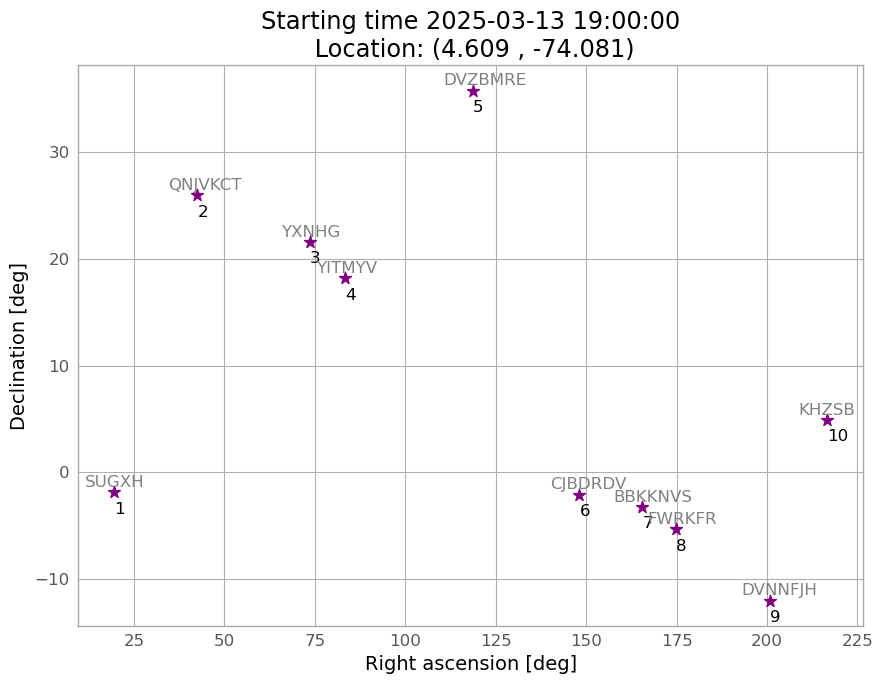

In [22]:
plt.style.use(astropy_mpl_style)
quantity_support()

names = [i for i in order100['Name'].drop_duplicates()]
ra = [Angle(i, unit=u.deg).degree for i in order100['RA'].drop_duplicates()]
dec = [Angle(i, unit=u.deg).degree for i in order100['DEC'].drop_duplicates()]
orderlabels = [i for i in order100['Label'].drop_duplicates()]

plt.figure(figsize=(9, 7))

plt.title('Starting time {}\n Location: ({} , {})'.format(date_i,observer[0],observer[1]))

plt.scatter(ra,dec,color='purple',marker='*', s=80)
for i in range(0, len(dec)):
    plt.text(ra[i]-8, dec[i]+0.5, str(names[i]), color='grey')
    plt.text(ra[i], dec[i]-2, str(i+1), color='k')
    
plt.ylabel(r"Declination [deg]",fontsize=14)
plt.xlabel(r'Right ascension [deg]',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## 1000 random targets

In [23]:
#Dataframe with random targets
alerts1000 = random_data(1000)

#Amount of targets, this is for the labels of graphic
many1000 = len(alerts1000) + 1

#Observations with the data
Data1000 = Observations(observer, alerts1000, date_i, date_f,timescale,many1000,limit,m_min)
time1000 = DeltaTime(date_i,date_f,timescale)
general_time1000 = CreateTime(date_i,date_f,timescale)
graphic1000, order1000 = OrderLimits(Data1000,many1000,time1000, general_time1000,t_expo,K,m_ref)

print('Order for observation')
order1000

Order for observation


,Name,RA,DEC,Mag,Label,Time,Time expo
0,XBXPDS,01h05m37.01s,+09d54m37.16s,10,938,2025-03-12 19:00:00.000,10.000000
1,UDIJP,02h10m11.51s,+06d41m22.56s,3,247,2025-03-12 19:15:19.149,0.015849
2,UDIJP,02h10m11.51s,+06d41m22.56s,3,247,2025-03-12 19:30:38.298,0.015849
3,UDIJP,02h10m11.51s,+06d41m22.56s,3,247,2025-03-12 19:45:57.447,0.015849
4,UDIJP,02h10m11.51s,+06d41m22.56s,3,247,2025-03-12 20:01:16.596,0.015849
5,UDIJP,02h10m11.51s,+06d41m22.56s,3,247,2025-03-12 20:16:35.745,0.015849
6,YEEBK,03h21m55.89s,-03d48m45.11s,7,518,2025-03-12 20:31:54.894,0.630957
7,YEEBK,03h21m55.89s,-03d48m45.11s,7,518,2025-03-12 20:47:14.043,0.630957
8,YEEBK,03h21m55.89s,-03d48m45.11s,7,518,2025-03-12 21:02:33.191,0.630957
9,ZXKAWR,04h05m20.28s,+06d30m44.18s,7,670,2025-03-12 21:17:52.340,0.630957


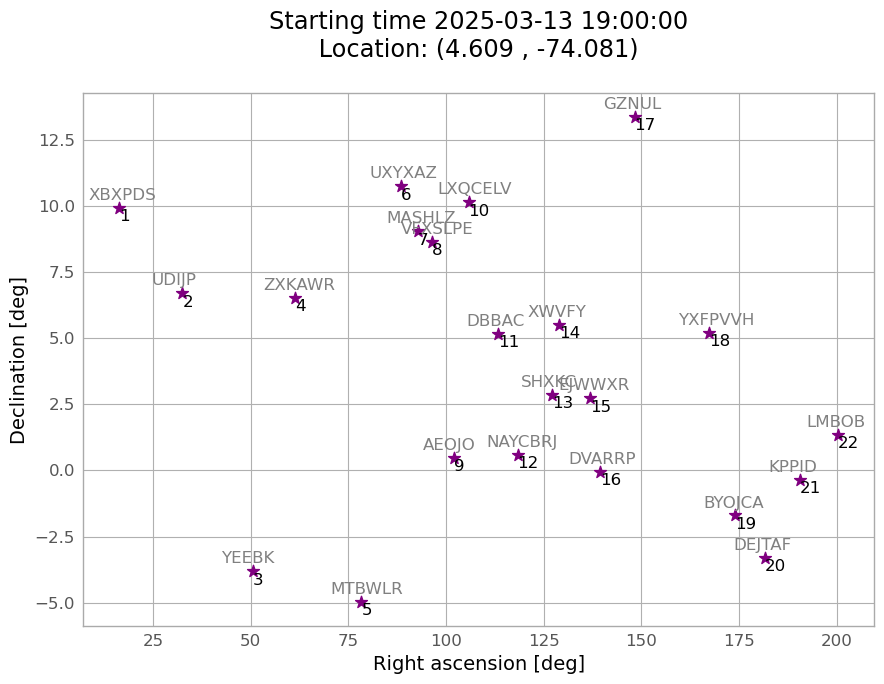

In [24]:
plt.style.use(astropy_mpl_style)
quantity_support()

names = [i for i in order1000['Name'].drop_duplicates()]
ra = [Angle(i, unit=u.deg).degree for i in order1000['RA'].drop_duplicates()]
dec = [Angle(i, unit=u.deg).degree for i in order1000['DEC'].drop_duplicates()]
orderlabels = [i for i in order1000['Label'].drop_duplicates()]

plt.figure(figsize=(9, 7))

plt.title('Starting time {}\n Location: ({} , {}) \n'.format(date_i,observer[0],observer[1]))

plt.scatter(ra,dec,color='purple',marker='*', s=80)
for i in range(0, len(dec)):
    plt.text(ra[i]-8, dec[i]+0.3, str(names[i]), color='grey')
    plt.text(ra[i], dec[i]-0.5, str(i+1), color='k')
    
plt.ylabel(r"Declination [deg]",fontsize=14)
plt.xlabel(r'Right ascension [deg]',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## 10000 random targets

In [25]:
#Dataframe with random targets
alerts10000 = random_data(10000)

#Amount of targets, this is for the labels of graphic
many10000 = len(alerts10000) + 1

#Observations with the data
Data10000 = Observations(observer, alerts10000, date_i, date_f,timescale,many10000,limit,m_min)
time10000 = DeltaTime(date_i,date_f,timescale)
general_time10000 = CreateTime(date_i,date_f,timescale)
graphic10000, order10000 = OrderLimits(Data10000,many10000,time10000, general_time10000,t_expo,K,m_ref)

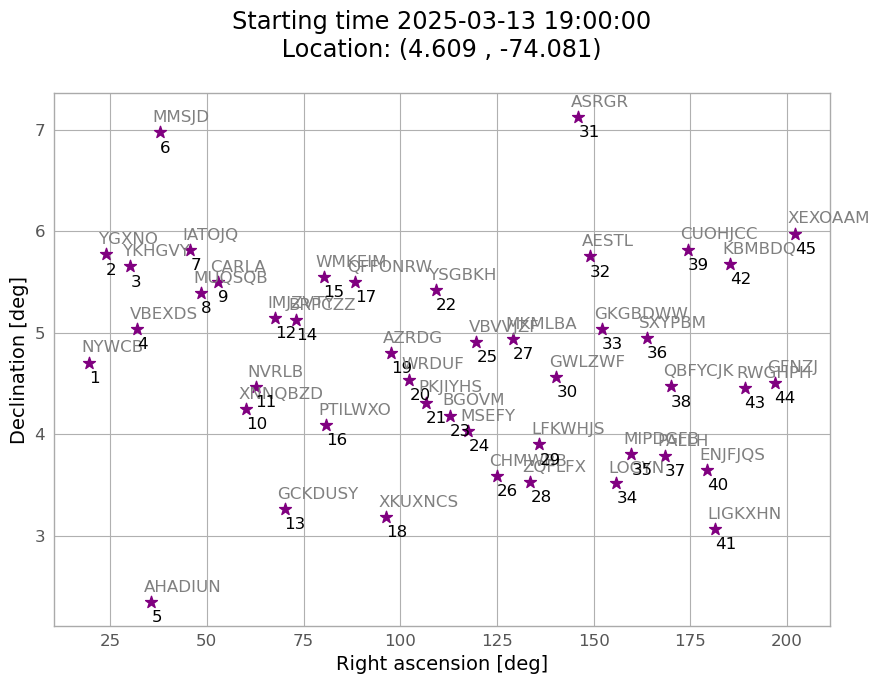

In [26]:
plt.style.use(astropy_mpl_style)
quantity_support()

names = [i for i in order10000['Name'].drop_duplicates()]
ra = [Angle(i, unit=u.deg).degree for i in order10000['RA'].drop_duplicates()]
dec = [Angle(i, unit=u.deg).degree for i in order10000['DEC'].drop_duplicates()]
orderlabels = [i for i in order10000['Label'].drop_duplicates()]

plt.figure(figsize=(9, 7))

plt.title('Starting time {}\n Location: ({} , {}) \n'.format(date_i,observer[0],observer[1]))

plt.scatter(ra,dec,color='purple',marker='*', s=80)
for i in range(0, len(dec)):
    plt.text(ra[i]-2, dec[i]+0.1, str(names[i]), color='grey')
    plt.text(ra[i], dec[i]-0.2, str(i+1), color='k')
    
plt.ylabel(r"Declination [deg]",fontsize=14)
plt.xlabel(r'Right ascension [deg]',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()